In [78]:
import os
import json
import torch
import numpy as np
from losses import MaskedMSELoss
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from matplotlib.ticker import MultipleLocator 
from models import TransformerEncoderInputter
from datasets import ImputationDataset, find_padding_masks

**Autoregressive denoising**  
Warm up model weights by filling in masked values

In [79]:
# Create model

# dropout = 0.1 dropout
# n_heads = 8 number of heads
# num_layers = 1 number of layers
# feat_dim = 35 number of features
# max_len = 40 max length of sequence
# d_model = 64 dimension of the model
# freeze = False freeze the model True --> no dropout
# dim_feedforward = 256 dimension of the feedforward layers within the transformer blocks
model = TransformerEncoderInputter(feat_dim=35,
                                    max_len=40,
                                    d_model=64, 
                                    n_heads=8, 
                                    num_layers=1,
                                    dim_feedforward=256, 
                                    dropout=0.1, 
                                    freeze=False)

# Create an instance of the model and set to float (default is double)
model.float();

In [80]:
# Read in train and validation indices

with open('../data/data_indices.json', 'r') as f: data_indices = json.load(f)
train_indices = data_indices['train_indices']
val_indices = data_indices['val_indices']

In [81]:
# Create loaders

train_dataloader = DataLoader(ImputationDataset(train_indices, norm_type='unity', mean_mask_length=3, masking_ratio=0.15), batch_size=10, shuffle=True, drop_last=True)
val_dataloader = DataLoader(ImputationDataset(val_indices, norm_type='unity', mean_mask_length=3, masking_ratio=0.15), batch_size=10, shuffle=True, drop_last=True)
x, mask, label = next(iter(train_dataloader))
x.shape, mask.shape, label.shape

(torch.Size([10, 40, 35]), torch.Size([10, 40, 35]), torch.Size([10]))

In [82]:
# Define the traning loop

def train_and_validate_inputer(model, train_loader, test_loader, n_epoch):

    best_test_loss = 1e20
    running_batch_loss_train = []
    running_batch_loss_test = []
    save_path = '../models/inputting_unity_norm.pt'
    if 'inputting_unity_norm.pt' in os.listdir(os.path.dirname(save_path)):os.remove(save_path)

    for epoch in range(n_epoch):
        print(epoch + 1)

        model.train()
        for x, mask, _ in train_loader:
            padding_mask = find_padding_masks(x) # shape (batchsize, max_seq_len) to pad start of short sequences
            x = torch.nan_to_num(x) # replace nan with 0 (since needs to be processed by the model)
            x_masked = x * mask # mask the input
            target_masks = ~mask  # inverse logic: 0 now means ignore, 1 means predict (when passed to the loss function)

            x = x.to(device)
            x_masked = x_masked.to(device)
            target_masks = target_masks.to(device)
            padding_mask = padding_mask.to(device)

            y_hat = model(x_masked, padding_mask)
            loss = critereon(y_hat, x, target_masks)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=4.0)
            optimizer.step()
            running_batch_loss_train.append(loss.item())

            model.eval()
            with torch.no_grad():
                x, mask, _ = next(iter(test_loader))
                padding_mask = find_padding_masks(x) 
                x = torch.nan_to_num(x)
                x_masked = x * mask 
                target_masks = ~mask 

                x = x.to(device)
                x_masked = x_masked.to(device)
                target_masks = target_masks.to(device)
                padding_mask = padding_mask.to(device)
      
                y_hat = model(x_masked, padding_mask)
                loss = critereon(y_hat, x, target_masks)
                running_batch_loss_test.append(loss.item())

            if loss < best_test_loss:
                best_test_loss = loss
                torch.save(model.state_dict(), save_path)

        print(f"Epoch Train Loss: {np.nanmean(running_batch_loss_train)}\nEpoch Test Loss: {np.nanmean(running_batch_loss_test)}")
                
    return running_batch_loss_train, running_batch_loss_test

In [83]:
# 1) traget = (batch, max_seq_len, feat_dim) tensor with missing values at the beginning replaced by 0
# 2) mask = (batch, max_seq_len, feat_dim) boolean tensor
# 3) padding_mask = (batch, max_seq_len) boolean tensor, 1 means keep, 0 means ignore dtype=torch.bool
# 4) x_masked = (batch, max_seq_len, feat_dim) tensor with missing values that follow a geometric distribution
# 5) target_masks = (batch, max_seq_len, feat_dim) boolean tensor 1 means area to calculate the loss on, opposite to mask

In [84]:
# Set device, initiate optimizer, define loss criterion, and set number of epoch

n_epoch = 50
critereon = MaskedMSELoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
running_batch_loss_train, running_batch_loss_test = train_and_validate(model, train_dataloader, val_dataloader, n_epoch)

1
Epoch Train Loss: 0.09263382876585972
Epoch Test Loss: 0.07911724641330932
2
Epoch Train Loss: 0.055888414407443056
Epoch Test Loss: 0.048964372823799125
3
Epoch Train Loss: 0.04320654719904588
Epoch Test Loss: 0.03839861412058797
4
Epoch Train Loss: 0.03691193145258646
Epoch Test Loss: 0.03308075716670014
5
Epoch Train Loss: 0.033030160643944616
Epoch Test Loss: 0.029971830086096336
6
Epoch Train Loss: 0.030390691682042784
Epoch Test Loss: 0.02780977221973763
7
Epoch Train Loss: 0.02849612473615242
Epoch Test Loss: 0.026232816846130935
8
Epoch Train Loss: 0.02708135944435765
Epoch Test Loss: 0.025016695962557078
9
Epoch Train Loss: 0.02594286184594558
Epoch Test Loss: 0.02412200813339642
10
Epoch Train Loss: 0.025015919947212462
Epoch Test Loss: 0.023380111851484368
11
Epoch Train Loss: 0.024274060001338357
Epoch Test Loss: 0.022740529224044827
12
Epoch Train Loss: 0.02363611458139004
Epoch Test Loss: 0.022193414471602363
13
Epoch Train Loss: 0.023095004539559726
Epoch Test Loss: 0.

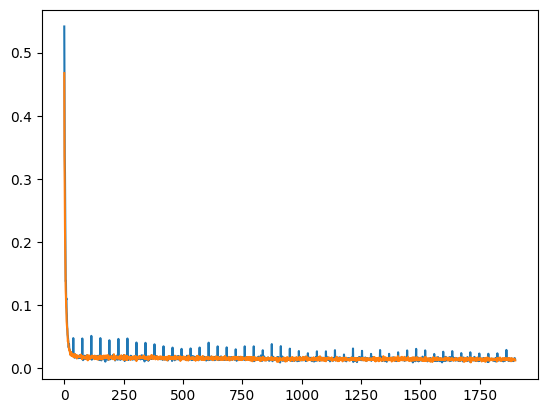

In [85]:
plt.plot(running_batch_loss_train)
plt.plot(running_batch_loss_test)

In [95]:
model.eval()
x, mask, _ = next(iter(val_dataloader))
padding_mask = find_padding_masks(x) 
x = torch.nan_to_num(x)
x_masked = x * mask 
target_masks = ~mask  
x = x.to(device)
x_masked = x_masked.to(device)
target_masks = target_masks.to(device)
padding_mask = padding_mask.to(device)
y_hat = model(x_masked, padding_mask)

print(f"Input shape: {x.shape}\nMask shape: {mask.shape}\nOutput shape: {y_hat.shape}")

Input shape: torch.Size([10, 40, 35])
Mask shape: torch.Size([10, 40, 35])
Output shape: torch.Size([10, 40, 35])


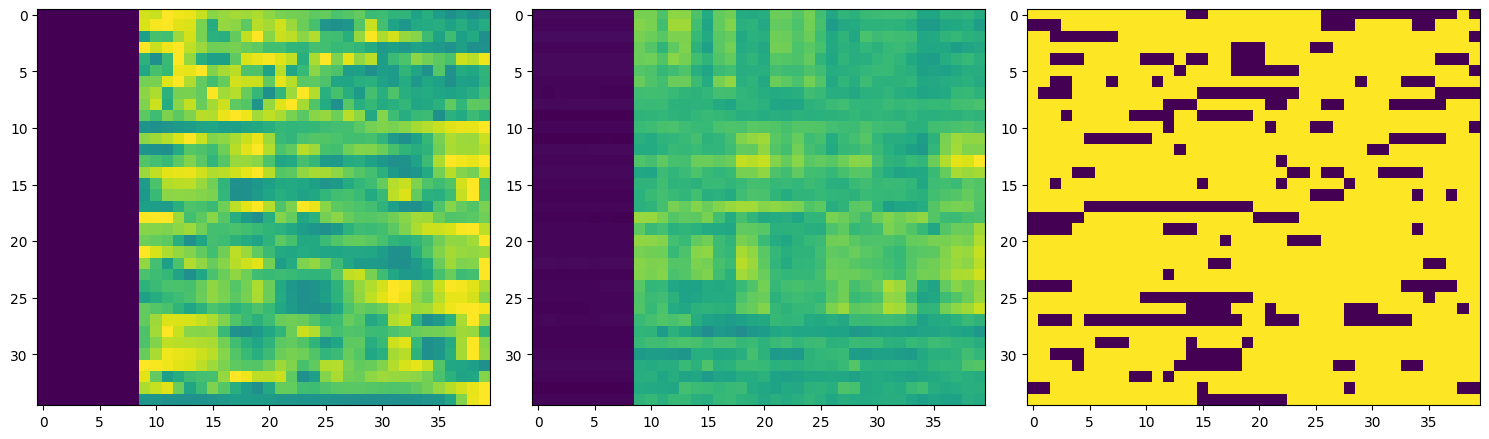

In [96]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(x[0].cpu().detach().numpy().T)
ax[1].imshow(y_hat[0].cpu().detach().numpy().T)
ax[2].imshow(mask[0].cpu().detach().numpy().T)
plt.tight_layout()
plt.show()


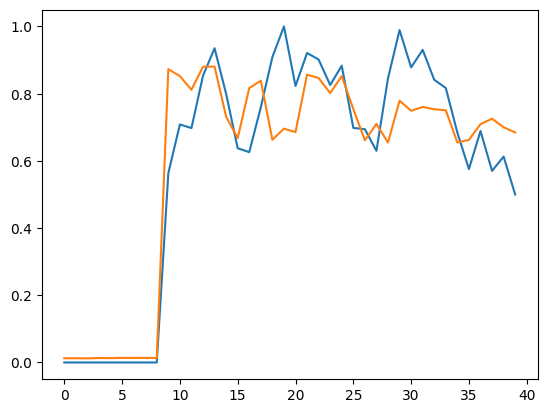

In [97]:
fet = 2
plt.plot(x[0, :, fet].cpu().detach().numpy(), label='original')
plt.plot(y_hat[0, :, fet].cpu().detach().numpy(), label='imputed')

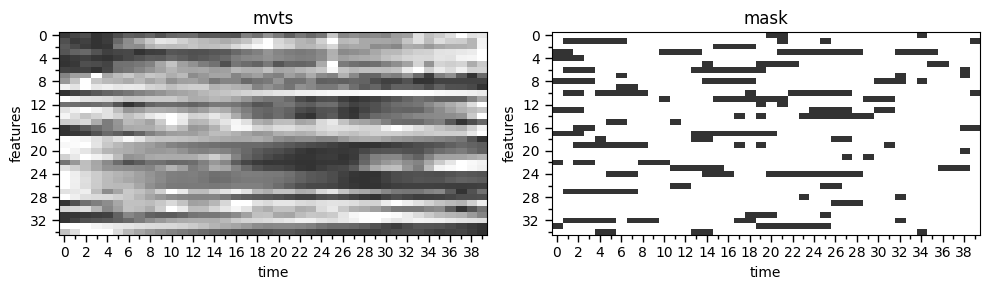

In [22]:
# Plot mvts and mask

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.set_title('mvts')
ax1.set_ylabel('features')
ax1.set_xlabel('time')
ax1.imshow(x[0, :, :].numpy().T, aspect='auto', alpha=0.8, cmap='gray')
ax1.xaxis.set_major_locator(MultipleLocator(2))
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_major_locator(MultipleLocator(4))
ax1.yaxis.set_minor_locator(MultipleLocator(2))
ax1.tick_params(which='major', length=5,width=1)
ax1.tick_params(which='minor', length=3,width=1)
ax2.set_title('mask')
ax2.set_ylabel('features')
ax2.set_xlabel('time')
ax2.imshow(mask[0, :, :].numpy().T, aspect='auto', alpha=0.8, cmap='gray')
ax2.xaxis.set_major_locator(MultipleLocator(2))
ax2.xaxis.set_minor_locator(MultipleLocator(1))
ax2.yaxis.set_major_locator(MultipleLocator(4))
ax2.yaxis.set_minor_locator(MultipleLocator(2))
ax2.tick_params(which='major', length=5,width=1)
ax2.tick_params(which='minor', length=3,width=1)
plt.tight_layout()
plt.show()
plt.close()